# Developing methods to calculate and generate the Activity Index (Miller 2001) as a metric for activity

In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import datetime as dt

import matplotlib.pyplot as plt
from matplotlib import colors
import soundfile as sf
import matplotlib.patches as patches
from pathlib import Path

In [2]:
import sys

sys.path.append("../src")

In [3]:
from core import SITE_NAMES, FREQ_GROUPS, DC_COLOR_MAPPINGS
from cli import get_file_paths

import bout_clustering as bt_clustering
import bout_plotting as bt_plt
import subsampling as ss
import data_handling as dh
import plotting
import pipeline

In [4]:
type_key = 'lf_'
site_key = "Carp"
# cycle_lengths = [1800, 720, 600, 360, 180, 60, 30, 6]
cycle_lengths = [1800, 360]
percent_ons = [0.1667]
specific_dc_tag = "1800of1800"

In [5]:
fig_details = dict()
fig_details['site_name'] = SITE_NAMES[site_key]
fig_details['freq_group'] = type_key.split('_')[0].upper()
if type_key:
    fig_details['freq_group'] = fig_details['freq_group'] + ' '

In [6]:
pipeline_params = dict()
pipeline_params["read_csv"] = True
pipeline_params["save_activity_grid"] = True
pipeline_params["save_presence_grid"] = True
pipeline_params["save_dc_night_comparisons"] = True
pipeline_params["save_activity_dc_comparisons"] = True
pipeline_params["save_presence_dc_comparisons"] = True
pipeline_params["show_plots"] = False
pipeline_params["show_PST"] = True
pipeline_params

{'read_csv': True,
 'save_activity_grid': True,
 'save_presence_grid': True,
 'save_dc_night_comparisons': True,
 'save_activity_dc_comparisons': True,
 'save_presence_dc_comparisons': True,
 'show_plots': False,
 'show_PST': True}

In [7]:
data_params = dict()
data_params["site_name"] = SITE_NAMES[site_key]
data_params["site_tag"] = site_key
data_params["type_tag"] = type_key
data_params["freq_tags"] = FREQ_GROUPS[type_key]
data_params["cycle_lengths"] = cycle_lengths
data_params["percent_ons"] = percent_ons
dc_tags = ss.get_list_of_dc_tags(data_params["cycle_lengths"], data_params["percent_ons"])
data_params["dc_tags"] = dc_tags
data_params["cur_dc_tag"] = specific_dc_tag
data_params['resolution_in_min'] = '30'
data_params['recording_start'] = '02:00'
data_params['recording_end'] = '13:30'
data_params

{'site_name': 'Carp Pond',
 'site_tag': 'Carp',
 'type_tag': 'lf_',
 'freq_tags': [13000, 43000],
 'cycle_lengths': [1800, 360],
 'percent_ons': [0.1667],
 'dc_tags': ['1800of1800', '300of1800', '60of360'],
 'cur_dc_tag': '1800of1800',
 'resolution_in_min': '30',
 'recording_start': '02:00',
 'recording_end': '13:30'}

In [8]:
file_paths = get_file_paths(data_params)
file_paths

{'raw_SITE_folder': '/Users/adityakrishna/duty-cycle-investigation/src/../data/raw/Carp',
 'SITE_folder': '/Users/adityakrishna/duty-cycle-investigation/src/../data/2022_bd2_summary/Carp',
 'bd2_TYPE_SITE_YEAR': 'bd2__lf_Carp_2022',
 'duty_cycled_folder': '/Users/adityakrishna/duty-cycle-investigation/src/../data/2022_bd2_summary/Carp/duty_cycled',
 'dc_dets_TYPE_SITE_summary': 'dc_dets_lf_Carp_summary',
 'dc_bouts_TYPE_SITE_summary': 'dc_bouts_lf_Carp_summary',
 'dc_inds_TYPE_SITE_summary': 'dc_inds_lf_Carp_summary',
 'simulated_schemes_folder': '/Users/adityakrishna/duty-cycle-investigation/src/../data/2022_bd2_summary/Carp/duty_cycled/simulated_schemes',
 'figures_SITE_folder': '/Users/adityakrishna/duty-cycle-investigation/src/../figures/Carp',
 'activity_det_comparisons_figname': 'activity_det_comparisons_per_dc_LF_Carp',
 'dc_det_comparisons_figname': 'dc_det_comparisons_per_night_LF_Carp',
 'activity_bout_comparisons_figname': 'activity_bout_comparisons_per_dc_LF_Carp',
 'dc_bou

### Below is the core of calculating the Activity Index.

### Dividing the recording period into smaller time blocks and detecting presence in each time block. 

### Finally the index is the sum of all detected presence in the original recording period.

In [36]:
activity_inds_arr = pd.DataFrame()

dc_tag = '1800of1800'

location_df = ss.prepare_summary_for_plotting_with_duty_cycle(file_paths, dc_tag)
location_df['ref_time'] = location_df['call_start_time']
temp = location_df.resample(f'5S', on='ref_time')['ref_time'].count()
temp

ref_time
2022-07-13 04:53:00    1
2022-07-13 04:53:05    0
2022-07-13 04:53:10    0
2022-07-13 04:53:15    0
2022-07-13 04:53:20    0
                      ..
2022-08-25 12:36:45    0
2022-08-25 12:36:50    0
2022-08-25 12:36:55    0
2022-08-25 12:37:00    1
2022-08-25 12:37:05    2
Freq: 5S, Name: ref_time, Length: 748610, dtype: int64

In [37]:
temp[temp>0] = 1
activity_indices = temp.resample(f"{data_params['resolution_in_min']}T").sum()
activity_indices

ref_time
2022-07-13 04:30:00     6
2022-07-13 05:00:00     8
2022-07-13 05:30:00    33
2022-07-13 06:00:00    19
2022-07-13 06:30:00    10
                       ..
2022-08-25 10:30:00    32
2022-08-25 11:00:00     6
2022-08-25 11:30:00     1
2022-08-25 12:00:00    28
2022-08-25 12:30:00    19
Freq: 30T, Name: ref_time, Length: 2081, dtype: int64

In [38]:
col_name = f"Activity Indices ({dc_tag})"
incomplete_activity_arr = pd.DataFrame(activity_indices.values, index=activity_indices.index, columns=[col_name])

all_processed_filepaths = sorted(list(map(str, list(Path(f'{file_paths["raw_SITE_folder"]}').glob('*.csv')))))
all_processed_datetimes = pd.to_datetime(all_processed_filepaths, format="%Y%m%d_%H%M%S", exact=False)

activity_arr = incomplete_activity_arr.reindex(index=all_processed_datetimes, fill_value=0).resample(f"{data_params['resolution_in_min']}T").first()
activity_arr = activity_arr.between_time(data_params['recording_start'], data_params['recording_end'], inclusive='left')

activity_inds_arr = pd.DataFrame(list(zip(activity_arr.index, activity_arr[col_name].values)), columns=["Date_and_Time_UTC", col_name])
activity_inds_arr.set_index('Date_and_Time_UTC', inplace=True)

### Once the activity array has been generated, the other methods for gridding and plotting are the same

In [39]:
activity_df = dh.construct_activity_grid_for_inds(activity_inds_arr, '1800of1800')

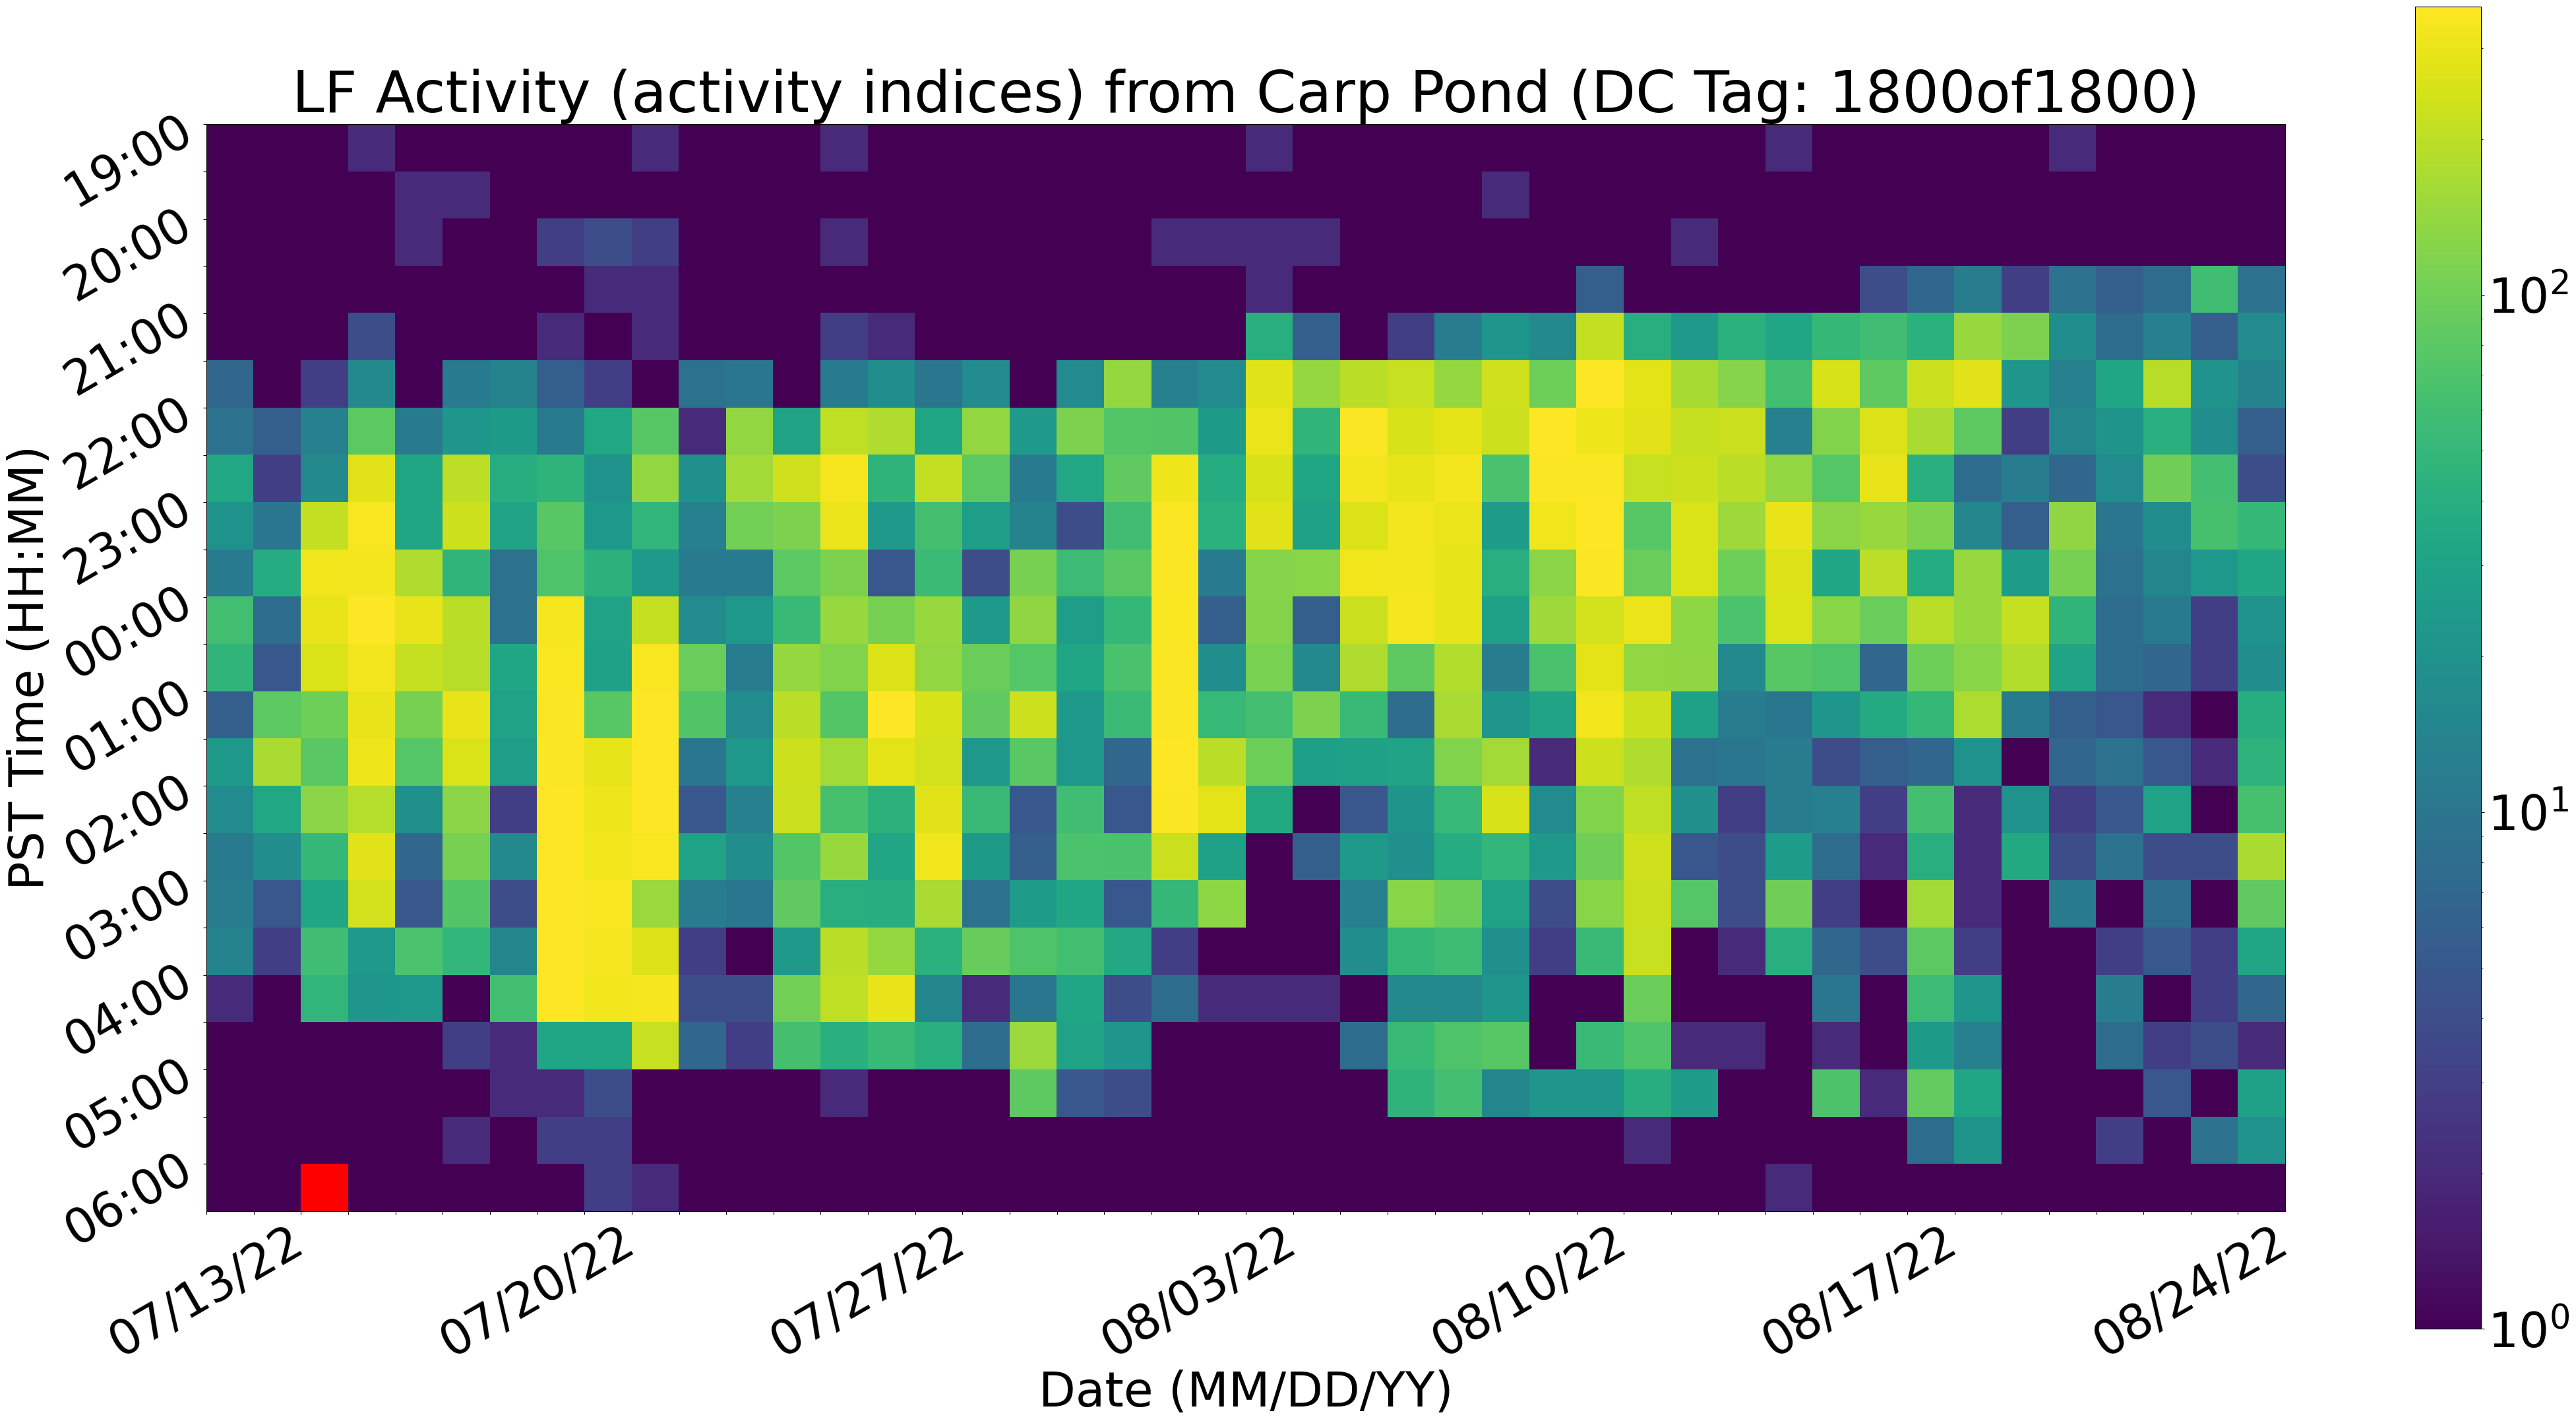

In [40]:
plotting.plot_activity_grid_for_inds(activity_df, data_params, pipeline_params, file_paths)

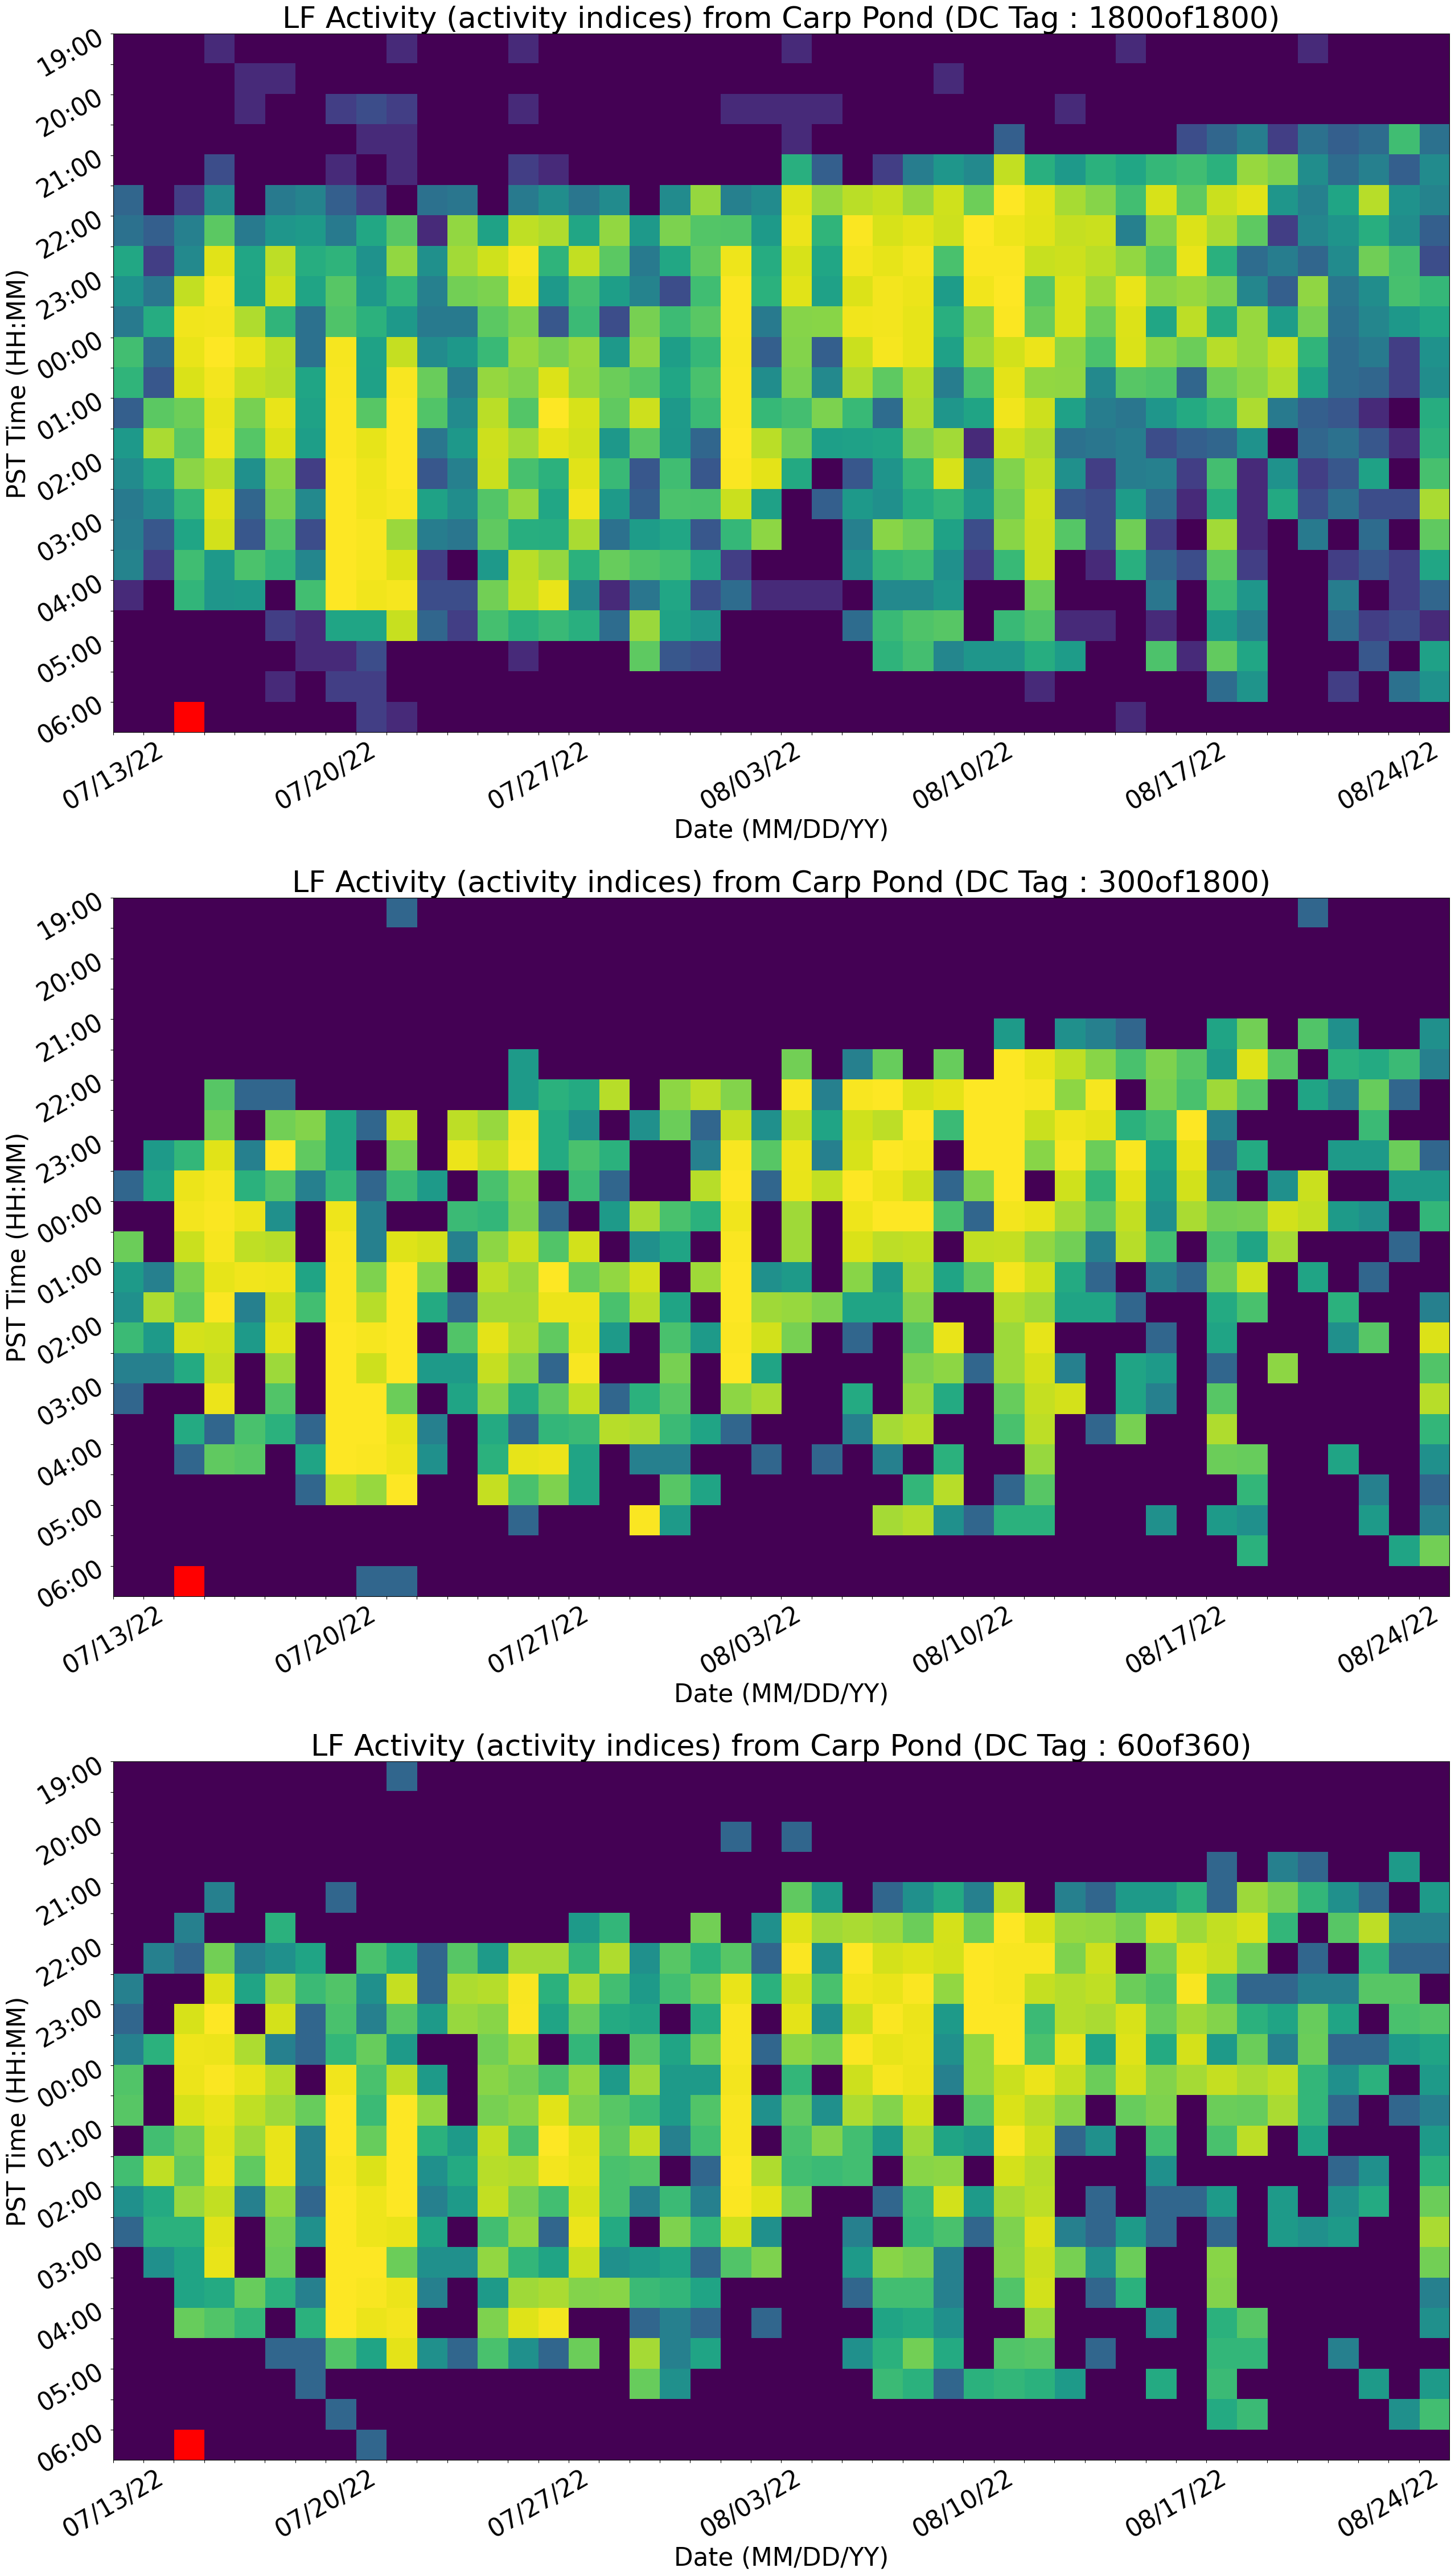

In [12]:
plotting.plot_dc_indices_activity_comparisons_per_scheme(activity_inds_arr, data_params, pipeline_params, file_paths)

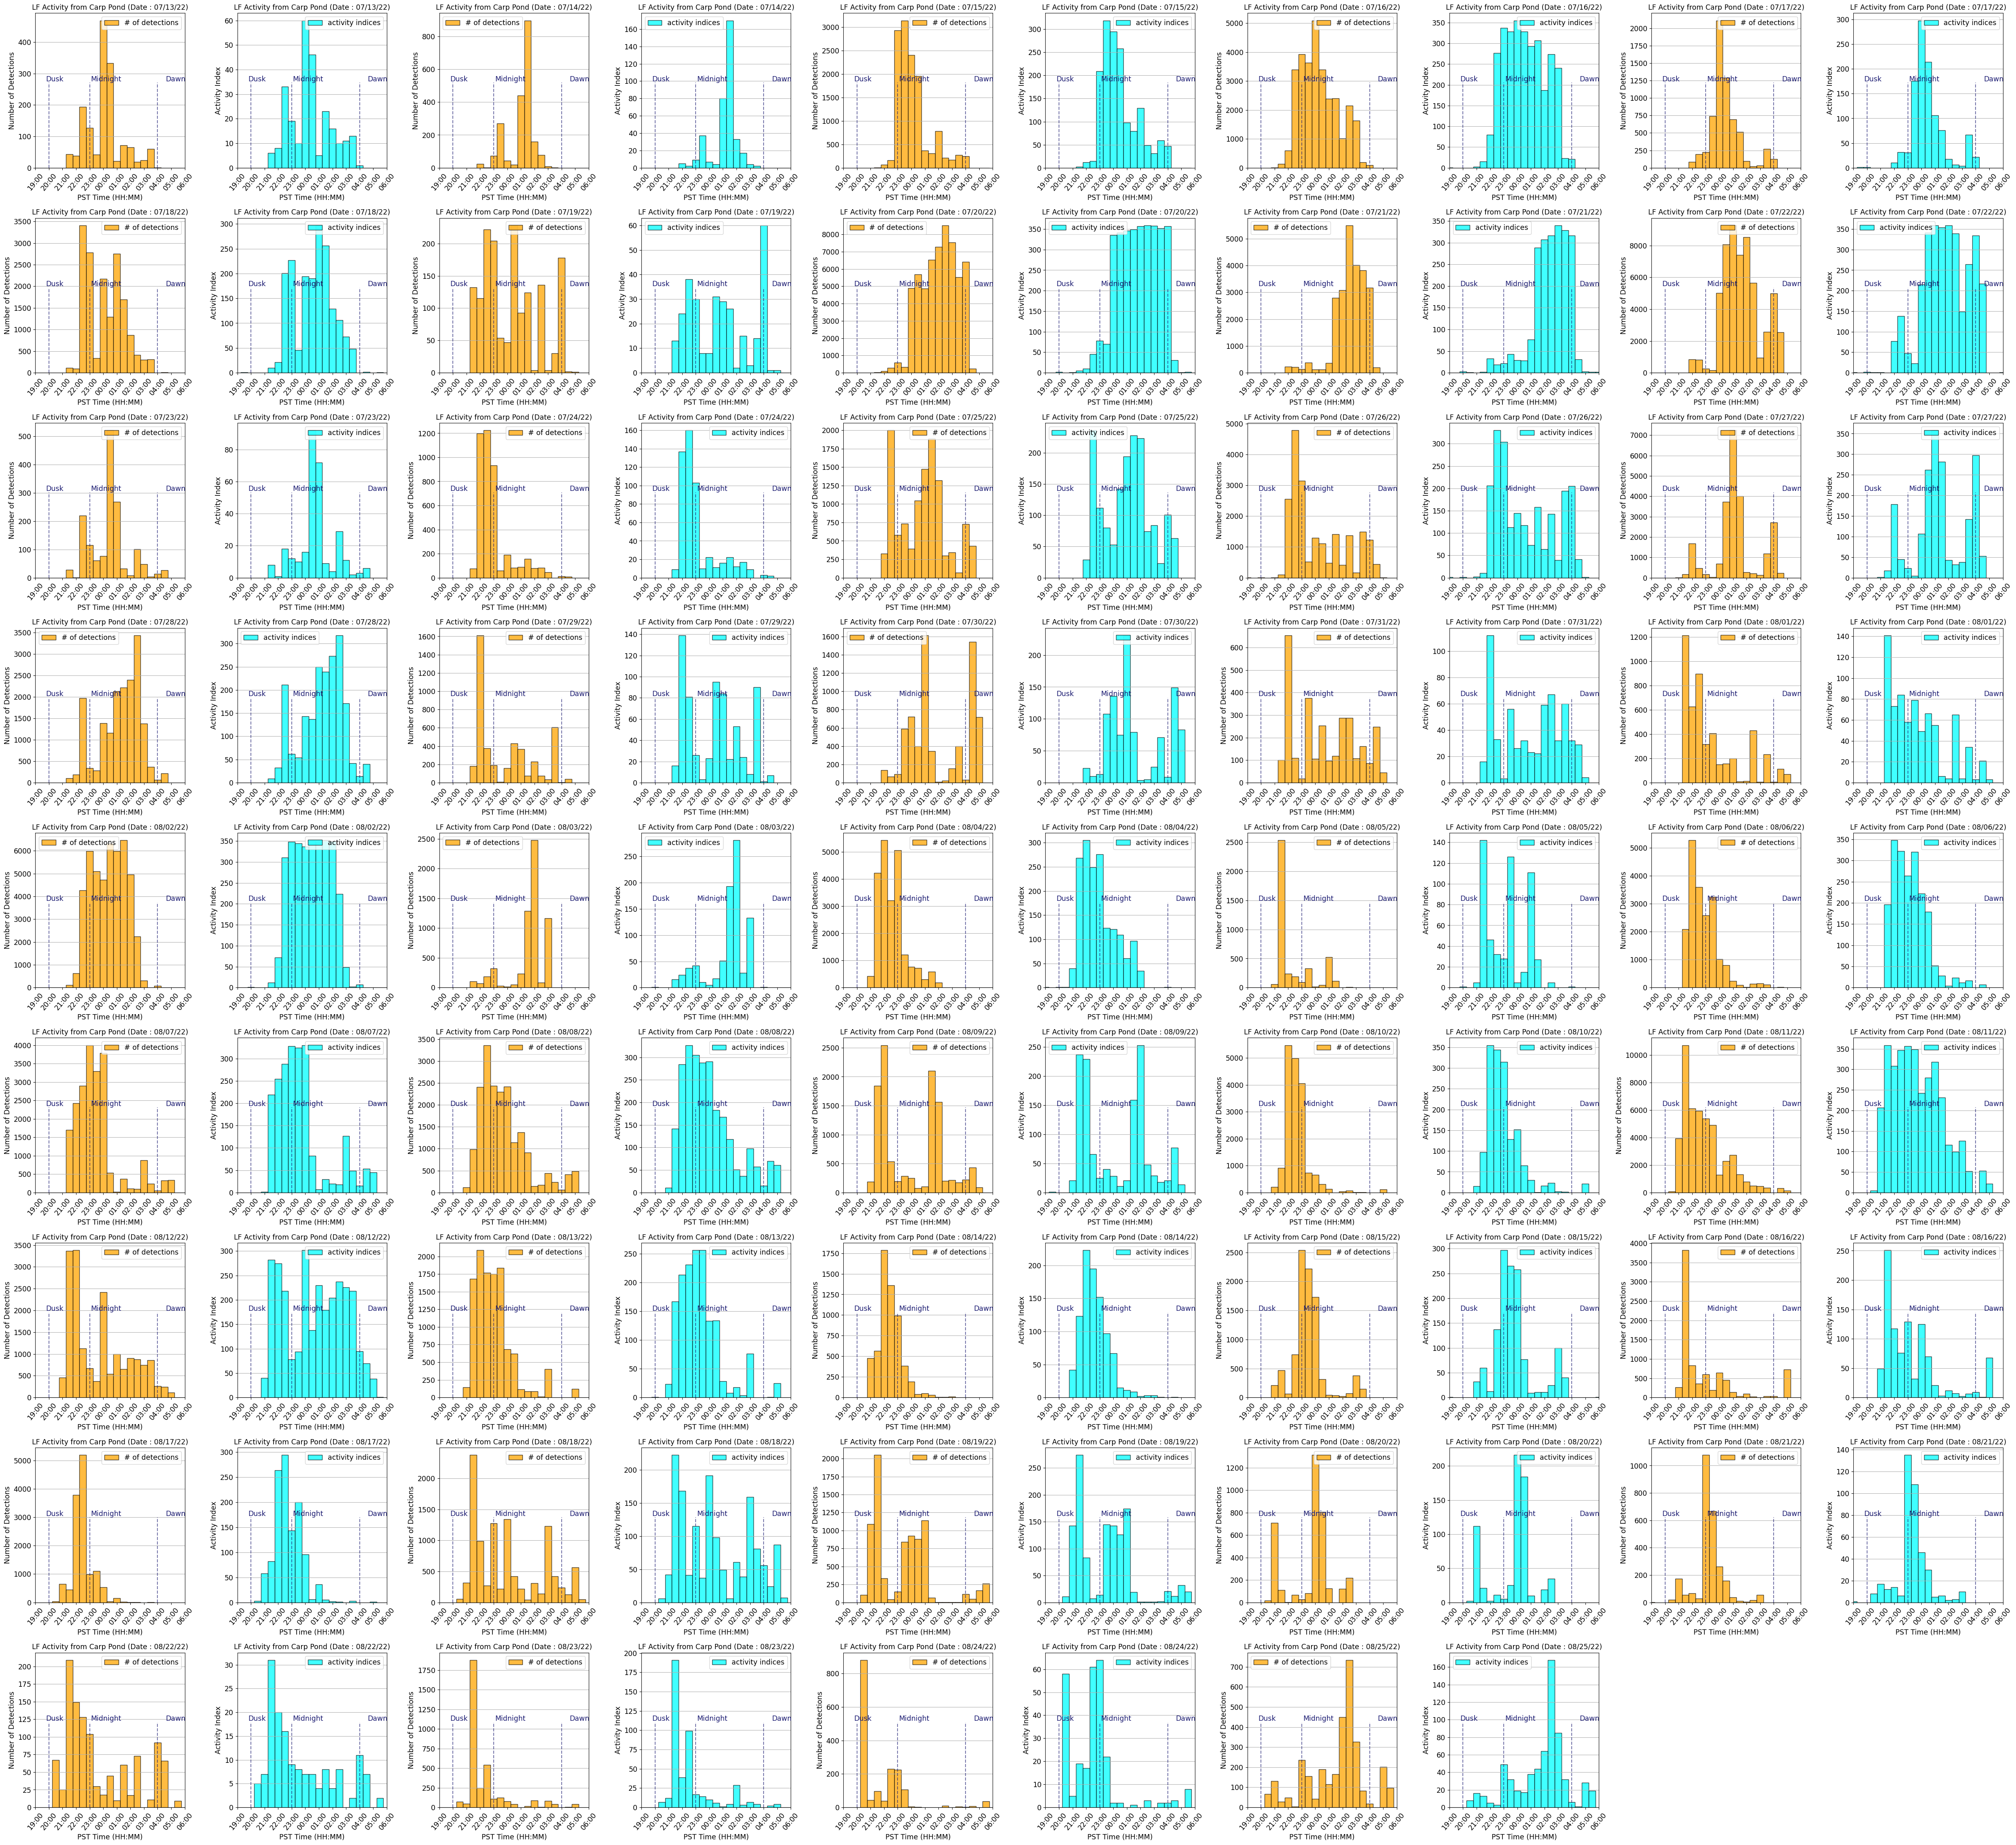

In [13]:
activity_dets_arr = pipeline.run_for_dets(data_params, pipeline_params, file_paths)
plotting.plot_numdets_n_activityinds(activity_dets_arr, activity_inds_arr, data_params, pipeline_params, file_paths)